In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [56]:
# Load data
mcdonalds = pd.read_csv("mcdonalds.csv")
# Convert "Yes" values to 1, "No" values to 0
mcdonalds.replace({"Yes": 1, "No": 0}, inplace=True)
#convert the negative reviews to -5 and, extremely postitive to 5 as we have some strings in the column
mcdonalds['Like'] = mcdonalds['Like'].replace('I hate it!-5', -5)
mcdonalds['Like'] = mcdonalds['Like'].replace('I love it!+5', 5)
mcdonalds['Like'] = mcdonalds['Like'].astype(int)

#convert frequency which is never to 0
mcdonalds['VisitFrequency'] = np.where(mcdonalds['VisitFrequency'] == 'Never', 0, 1)
# convert male ad females to 1s and 0s   #All these changes are done as we have to get the classification tree which won't take string inputs
mcdonalds['Gender'] = np.where(mcdonalds['Gender'] == 'Female', 0, 1)


In [57]:
# Perform PCA
scaler = StandardScaler()
MD_x = scaler.fit_transform(mcdonalds.iloc[:, 0:11])

pca = PCA()
MD_pca = pca.fit_transform(MD_x)

In [58]:
# Perform K-means clustering
np.random.seed(1234)
kmeans = KMeans(n_clusters=8, random_state=1234)
MD_km28 = kmeans.fit_predict(MD_x)
MD_k4 = KMeans(n_clusters=4, random_state=1234).fit_predict(MD_x)


In [59]:
# Perform Gaussian Mixture Model clustering
np.random.seed(1234)
gmm = GaussianMixture(n_components=8, random_state=1234)
MD_m28 = gmm.fit(MD_x)
MD_m4 = GaussianMixture(n_components=4, random_state=1234).fit(MD_x)

In [60]:
# Reverse table for 'Like' column
like_reverse = mcdonalds["Like"].value_counts().sort_index(ascending=False)


# Create 'Like.n' column
mcdonalds["Like.n"] = 6 - pd.to_numeric(mcdonalds["Like"], errors="coerce")

In [61]:
# Create formula for regression
feature_columns = mcdonalds.columns[0:11]
f = "Like.n ~ " + " + ".join(feature_columns)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


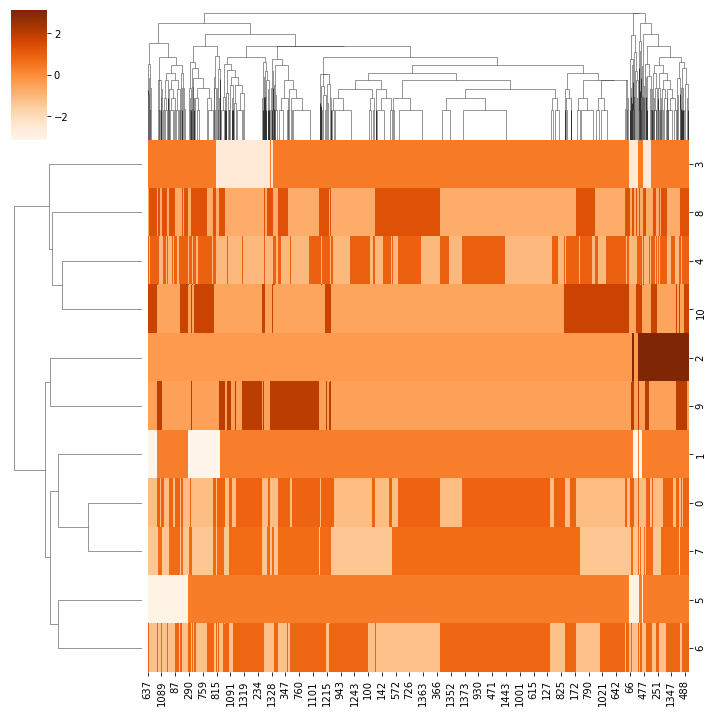

In [62]:
# Hierarchical clustering
MD_vclust = sns.clustermap(MD_x.T, metric='euclidean', method='complete', cmap="Oranges")

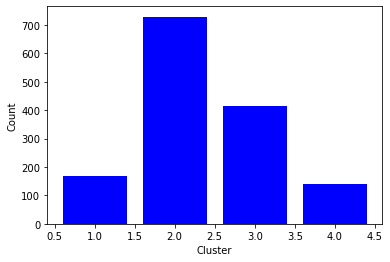

In [63]:
# Barchart for cluster 4
plt.bar(range(1, max(MD_k4) + 2), np.bincount(MD_k4[::-1]), color="blue")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

<AxesSubplot:>

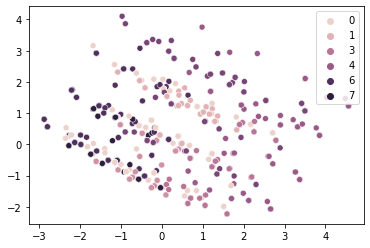

In [64]:
# Scatter plot of PCA with cluster colors
sns.scatterplot(x=MD_pca[:, 0], y=MD_pca[:, 1], hue=MD_km28)

<AxesSubplot:xlabel='Like', ylabel='row_0'>

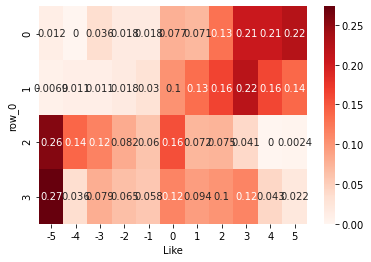

In [65]:
# Mosaic plot for cluster and 'Like' column
mosaic_like = pd.crosstab(MD_k4, mcdonalds["Like"], normalize="index")
sns.heatmap(mosaic_like, annot=True, cmap="Reds")


<AxesSubplot:xlabel='Gender', ylabel='row_0'>

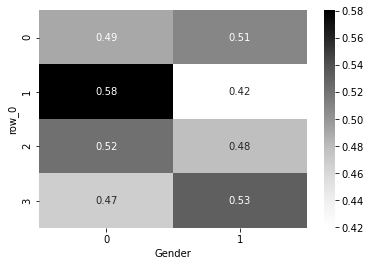

In [66]:
# Mosaic plot for cluster and 'Gender' column
mosaic_gender = pd.crosstab(MD_k4, mcdonalds["Gender"], normalize="index")
sns.heatmap(mosaic_gender, annot=True, cmap="Greys")

[Text(127.54285714285714, 201.90857142857143, 'X[7] <= 0.5\ngini = 0.644\nsamples = 1453\nvalue = [169, 729, 416, 139]'),
 Text(47.82857142857143, 170.84571428571428, 'X[5] <= 0.5\ngini = 0.434\nsamples = 517\nvalue = [29, 28, 378, 82]'),
 Text(31.885714285714286, 139.78285714285715, 'gini = 0.0\nsamples = 82\nvalue = [0, 0, 0, 82]'),
 Text(63.77142857142857, 139.78285714285715, 'X[3] <= 0.5\ngini = 0.236\nsamples = 435\nvalue = [29, 28, 378, 0]'),
 Text(31.885714285714286, 108.72, 'X[4] <= 0.5\ngini = 0.213\nsamples = 33\nvalue = [29, 0, 4, 0]'),
 Text(15.942857142857143, 77.65714285714284, 'gini = 0.0\nsamples = 26\nvalue = [26, 0, 0, 0]'),
 Text(47.82857142857143, 77.65714285714284, 'X[12] <= 46.5\ngini = 0.49\nsamples = 7\nvalue = [3, 0, 4, 0]'),
 Text(31.885714285714286, 46.59428571428572, 'gini = 0.0\nsamples = 3\nvalue = [3, 0, 0, 0]'),
 Text(63.77142857142857, 46.59428571428572, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 4, 0]'),
 Text(95.65714285714286, 108.72, 'X[0] <= 0.5\ngin

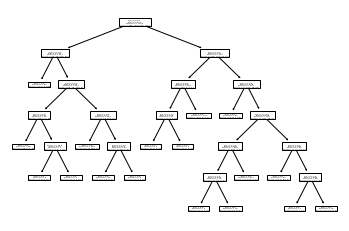

In [67]:
# Classification tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_formula = "np.where(MD_k4 == 3, 1, 0) ~ Like.n + Age + VisitFrequency + Gender"
tree_data = mcdonalds.assign(MD_k4=MD_k4)
tree = DecisionTreeClassifier(random_state=1234)
tree.fit(tree_data.drop("MD_k4", axis=1), tree_data["MD_k4"])
plot_tree(tree)

In [68]:
# Average visit frequency by cluster
visit = mcdonalds.groupby(MD_k4)["VisitFrequency"].mean()

print(visit)
# Average 'Like' by cluster
like = mcdonalds.groupby(MD_k4)["Like.n"].mean()
print(like)

# Percentage of females by cluster
female = mcdonalds.groupby(MD_k4)["Gender"].apply(lambda x: np.mean(x == "Female"))
print(female)

0    0.988166
1    0.982167
2    0.769231
3    0.856115
Name: VisitFrequency, dtype: float64
0    3.313609
1    3.706447
2    8.057692
3    7.014388
Name: Like.n, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
Name: Gender, dtype: float64


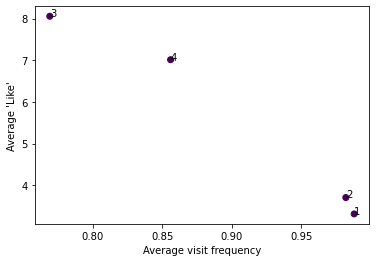

In [73]:
plt.scatter(visit, like, c=10 * female)
for i, label in enumerate(range(1, 5)):
    plt.text(visit[i], like[i], label)

plt.xlabel("Average visit frequency")
plt.ylabel("Average 'Like'")
plt.show()